In [74]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("../"))

from src.preprocess import preprocess



%load_ext autoreload
%autoreload 2
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
#load data into dataframe
filepath = '../data/raw_data.csv'
raw_df = pd.read_csv(filepath)

In [78]:
final_df = preprocess(raw_df)

In [80]:
final_df.shape[1]//2

21

In [82]:
final_df

,DefaultedAdvances,AdvanceAmount,CurrentBalance,LatefeesTotalCount,CreditAccounts,LastRepaymentAmount,OverdraftCount,OverdraftTotal,AverageMonthlySpend,BalanceAverage,BalanceMin,TotalAssets,AverageNumberOfTransactionsADay,TotalCash,LatefeesCount,Paycheck,TotalHistoryInDays,AverageMonthlyIncome,AverageMonthlyDiscretionarySpend,CheckingAccountCount,CreditAccountCount,SavingsAccountCount,OutstandingCreditDebtWherePayingInterest,AverageNumberOfTransactionsADayPrimaryChecking,NegativeBalanceCount,NumberOfMatches,ErrorRate,IsNameBased,BalanceAbove100L30Count,AveragePotentialMonthlyIncome,HasEmpowerBanking,bal_vol_index,dep_wd_ratio,od_per_30d,CurrentBalance_missing,PaycheckModelUsed_missing,NumberOfMatches_missing,ErrorRate_missing,IsNameBased_missing,PaycheckModel_BruteForce,PaycheckModel_DeepSearch,PaycheckModel_Tagging,PaycheckModel_VariableIncomeInMonth
0,0,50,268.10,0,0,0.0,0,0,-5491.060000,345.11,-185.34,268.10,4.633333,268.10,0,2457.000000,61.179873,3969.461181,-1191.270000,1,0,1,0.0,4.633333,11,5.0,0.0,1.0,18,4398.506667,1,-0.537046,-1.383326,0.000000,0,0,0,0,0,1,0,0,0
1,0,50,17.68,0,0,0.0,0,0,-1330.759925,378.01,0.08,17.72,1.647577,17.72,0,1706.900000,128.706924,1120.506790,-1503.200000,1,0,2,0.0,4.763780,0,7.0,0.0,0.0,28,3436.180000,0,0.000212,-1.187641,0.000000,0,0,0,0,0,1,0,0,0
2,0,50,0.79,0,0,0.0,0,0,-6446.753876,559.13,-276.61,273.99,4.080935,273.99,0,4630.347222,558.401660,6674.567286,-1546.523333,1,0,1,0.0,3.562950,20,5.0,0.0,1.0,16,6803.280000,1,-0.494715,-0.965868,0.000000,0,0,0,0,0,1,0,0,0
3,0,50,-12.83,0,0,0.0,0,0,-1904.714237,124.86,-44.62,645.12,2.831579,645.12,0,1300.000000,285.776868,1787.241711,-940.616667,1,0,1,0.0,2.729825,15,3.0,0.0,0.0,15,0.000000,0,-0.357360,-1.065728,0.000000,0,0,0,0,0,1,0,0,0
4,0,50,55.88,0,0,0.0,0,0,-5857.241057,420.26,42.50,55.88,8.926829,55.88,0,3633.073333,165.990591,5169.470216,-1893.433333,1,0,0,0.0,8.926829,0,3.0,0.0,0.0,24,7390.746667,1,0.101128,-1.133045,0.000000,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11803,1,50,730.68,0,0,0.0,1,1,-2303.885348,66.01,-471.14,1528.57,2.230769,1528.57,0,2095.802222,91.959145,2385.634137,-136.053333,1,0,0,0.0,2.230769,16,5.0,0.0,1.0,15,3208.086667,0,-7.137403,-0.965733,0.326232,0,0,0,0,0,1,0,0,0
11804,1,50,20.31,0,0,0.0,0,0,-2192.362597,122.33,5.31,20.31,0.820225,20.31,0,1170.000000,89.487968,2426.255609,-905.843333,1,0,0,0.0,0.820225,0,3.0,0.0,0.0,14,2076.476667,1,0.043407,-0.903599,0.000000,0,0,0,0,0,1,0,0,0
11805,1,50,0.00,0,0,0.0,0,0,-2398.152500,57.59,-199.82,-4.99,3.642137,-4.99,0,1228.860000,992.066940,2344.878447,-369.813333,2,0,1,0.0,3.000000,21,5.0,0.0,1.0,0,955.790000,1,-3.469700,-1.022719,0.000000,0,0,0,0,0,1,0,0,0
11806,1,50,15.51,0,0,0.0,1,19,-1660.517003,158.86,-111.02,15.51,1.222222,15.51,0,1733.333333,434.114083,1604.881041,-332.120000,1,0,0,0.0,1.222222,13,3.0,0.0,0.0,9,0.000000,0,-0.698854,-1.034667,0.069106,0,0,0,0,0,1,0,0,0


## Planned approach

1. baseline xgboost feature importance  - remove most unimportant features
2. RFE

### Approach 1: RFE with random forest

Observations:
1. RFE is fairly robust but has a few weakneses: computationaly expensive for large datasets, requires some intuition on selecting the number of features, depends heavily on estimator used
2. model name encoded features are not selected, confirming previous hypothesis


In [89]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [91]:
estimator = RandomForestClassifier()
n_features_to_select = final_df.shape[1]//2
step=1

In [93]:
rfe = RFE(estimator=estimator, 
              n_features_to_select=n_features_to_select, 
              step=step)

In [95]:
X_df = final_df.drop('DefaultedAdvances', axis=1)
y = final_df['DefaultedAdvances']

In [99]:
rfe.fit(X_df, y)

RFE(estimator=RandomForestClassifier(), n_features_to_select=21)

In [106]:
# Get selected features
selected_indices = np.where(rfe.support_)[0]
selected_features = X_df.columns[selected_indices].tolist()

# Calculate cross-validation score with selected features
X_selected = X_df.iloc[:, selected_indices]
cv_scores = cross_val_score(estimator, X_selected, y, cv=5)
mean_cv_score = cv_scores.mean()

In [112]:
# Create feature ranking DataFrame
feature_ranking = pd.DataFrame({
    'feature': X_df.columns,
    'ranking': rfe.ranking_,
    'selected': rfe.support_
}).sort_values('ranking')



feature_ranking

,feature,ranking,selected
20,SavingsAccountCount,1,True
24,NumberOfMatches,1,True
23,NegativeBalanceCount,1,True
22,AverageNumberOfTransactionsADayPrimaryChecking,1,True
28,AveragePotentialMonthlyIncome,1,True
17,AverageMonthlyDiscretionarySpend,1,True
16,AverageMonthlyIncome,1,True
15,TotalHistoryInDays,1,True
14,Paycheck,1,True
12,TotalCash,1,True


In [114]:
selected_features

['CurrentBalance',
 'OverdraftTotal',
 'AverageMonthlySpend',
 'BalanceAverage',
 'BalanceMin',
 'TotalAssets',
 'AverageNumberOfTransactionsADay',
 'TotalCash',
 'Paycheck',
 'TotalHistoryInDays',
 'AverageMonthlyIncome',
 'AverageMonthlyDiscretionarySpend',
 'SavingsAccountCount',
 'AverageNumberOfTransactionsADayPrimaryChecking',
 'NegativeBalanceCount',
 'NumberOfMatches',
 'BalanceAbove100L30Count',
 'AveragePotentialMonthlyIncome',
 'bal_vol_index',
 'dep_wd_ratio',
 'od_per_30d']

## Approach 2:  XGBoost Feature importance

Observations

1. Difficult to compare relative ranking since RFE does not show indvidual ranking within top 21 features.
2. similar features were eliminated using same top n feature count
3. Final choice - remove all features with zero weight

In [127]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [121]:
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.20, random_state=75454)

In [145]:
model = xgb.XGBClassifier()

In [147]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [155]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

<Figure size 2000x1500 with 0 Axes>

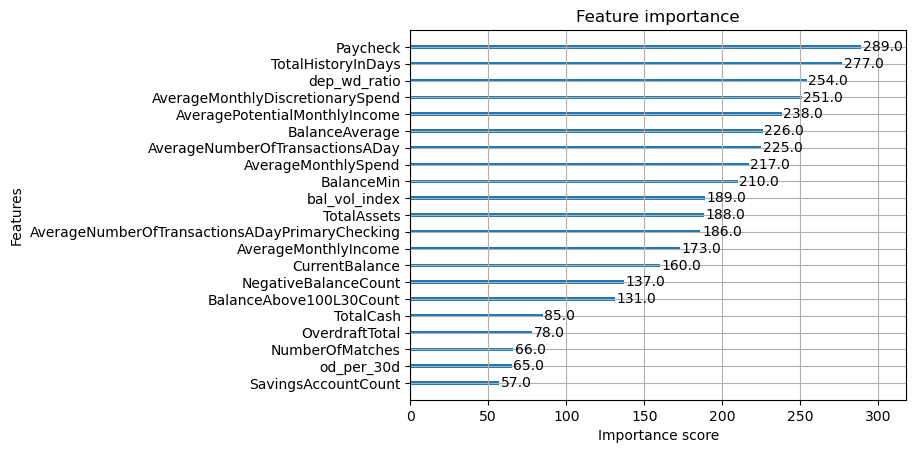

In [171]:
plt.figure(figsize=(20, 15))
plot_importance(model, max_num_features = n_features_to_select )
plt.show()

In [188]:

importances = model.feature_importances_

feature_names = model.feature_names_in_


importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort by importance and get top N
top_features_df = importance_df.sort_values('importance', ascending=False).head(25)


AttributeError: 'XGBClassifier' object has no attribute 'get_score'

In [191]:
top_features_df.reset_index()

,index,feature,importance
0,6,OverdraftTotal,0.046237
1,8,BalanceAverage,0.044463
2,12,TotalCash,0.038630
3,1,CurrentBalance,0.035849
4,33,CurrentBalance_missing,0.034701
5,24,NumberOfMatches,0.033843
6,17,AverageMonthlyDiscretionarySpend,0.033813
7,4,LastRepaymentAmount,0.033664
8,25,ErrorRate,0.033193
9,23,NegativeBalanceCount,0.031843


In [193]:
top_features_df.loc[top_features_df['importance']>0]

,feature,importance
6,OverdraftTotal,0.046237
8,BalanceAverage,0.044463
12,TotalCash,0.038630
1,CurrentBalance,0.035849
33,CurrentBalance_missing,0.034701
24,NumberOfMatches,0.033843
17,AverageMonthlyDiscretionarySpend,0.033813
4,LastRepaymentAmount,0.033664
25,ErrorRate,0.033193
23,NegativeBalanceCount,0.031843
